__Нейросетевая языковая модель на основе Tranformer__

Евгений Борисов <esborisov@sevsu.ru>

---

Attention Is All You Need  (2017)    
https://arxiv.org/abs/1706.03762

Нейчев Радослав  Машинное обучение. 4. Self-Attention. Transformer overview. Лекторий ФПМИ, 2020   
https://www.youtube.com/watch?v=UETKUIlYE6g


ML: Attention - Механизм внимания    
https://qudata.com/ml/ru/NN_Attention.html
    
    
Jay Alamma  The Illustrated Transformer. 2020    
https://jalammar.github.io/illustrated-transformer/

Jay Alammar Transformer в картинках. (Перевод - Е.Смирнова, С. Шкарин)   
https://habr.com/ru/articles/486358/

Jay Alammar  GPT-2 в картинках (визуализация языковых моделей Трансформера).  (Перевод - Е.Смирнова, С. Шкарин)     
https://habr.com/ru/articles/490842/

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

%precision 3
np.set_printoptions(precision=2)
np.set_printoptions(linewidth=110)
# np.get_printoptions()

# загружаем тексты

In [2]:
import gzip
import requests
from bs4 import BeautifulSoup

In [3]:
# url='http://lib.ru/NEWPROZA/LOBAS/taxisty.txt'
# text = BeautifulSoup(requests.get(url).text).get_text()
# with gzip.open('taxisty.txt.gz','wt') as f: f.write(text)

with gzip.open('taxisty.txt.gz','rt') as f: text = f.read()

text = text[1030:-7261].strip() # выкидываем заголовок и хвост страницы 
print(f'символов:{len(text)}\n---------------\n'%())
print(text[:343])

символов:637765
---------------

Вы прилетели в  Нью-Йорк и  остановились  в  одном  из отелей, глядящих
окнами на Центральный парк.  Наутро по  приезде вы вышли из  отеля, вдохнули
полной грудью очищенный зеленью парка воздух  и,  взглянув на часы, --  пора
было начинать хлопотливый день, --  направились к  первому из  таксомоторов,
выстроившихся вереницей у подъезда.
    


In [4]:
# url='http://az.lib.ru/d/dostoewskij_f_m/text_0080.shtml'
# text = BeautifulSoup(requests.get(url).text).get_text()
# with gzip.open('dostoewskij.txt.gz','wt') as f: f.write(text)

# # with gzip.open('dostoewskij.txt.gz','rt') as f: text = f.read()

# text = text[2876:-664184].strip() # выкидываем заголовок и хвост страницы 
# print(f'символов:{len(text)}\n---------------\n'%())
# print(text[:355])

---

In [5]:
from tqdm.auto import tqdm
from itertools import chain
import numpy as np

In [6]:
from nltk import __version__ as nltk_version
print('nltk version:',nltk_version)

from nltk.tokenize import sent_tokenize as nltk_sentence_split
from nltk.tokenize import word_tokenize as nltk_tokenize_word
from nltk.util import ngrams

nltk version: 3.8.1


In [7]:
# !pip install torch

In [8]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F

In [9]:
# !pip install torchtext

In [10]:
# import torchtext
# from torchtext.data import get_tokenizer

In [11]:
class Seq2SeqDataset(Dataset):
    
    def __init__( self, text, seq_len ):
        assert seq_len>1
        assert len(text)>1
        
        # служебные токены 
        self._tokens = ['<UNK>','<BOS>','<EOS>',]
        # self._tokens = ['<PAD>','<BOS>','<UNK>','<EOS>',]
        
        self._seq_len = seq_len # количество слов контекста слева
        
        # выполняем токенизацию текста 
        self._sentences = [ 
            nltk_tokenize_word(s,language='russian') # разбиваем предложения на слова
            for s in tqdm(nltk_sentence_split(text,language='russian')) # режем текст на отдельные предложения
        ]
        # строим словарь
        self._vocabulary = self._build_vocabulary(self._sentences)
        # выкидываем короткие предложения, добавляем служебный токен "конец последовательности"
        self._sentences = [ s + [ '<EOS>' ] for s in self._sentences if len(s)> self._seq_len*2 ]
        # собираем n-граммы длинны context_len+1
        self._data = self._encode_ngrams( self._build_ngrams(self._sentences) )
        
    def _build_vocabulary(self,sentences):        
        # собираем токены (слова) из текста, добавляем служебные
        text_tokens = self._tokens + sorted( set(chain(*sentences))-set(self._tokens) )
        # text_tokens = self._tokens[:-1] + sorted( set(chain(*sentences))-set(self._tokens) ) +[self._tokens[-1] ]
        return { w:n for n,w in enumerate(text_tokens) } # строим словарь
    
    def _build_ngrams(self, sentences):
        return [ # нарезаем последовательности токенов на n-граммы
            ng for s in tqdm(sentences)  
               for ng in ngrams( s, self._seq_len*2 ) 
        ]
    
    def _encode_ngrams(self,ngrams): # заменяем токены в n-граммах на номера в словаре
        return torch.tensor([ self.encode(ng) for ng in tqdm(ngrams) ], dtype=torch.long ) 
    
    def encode(self,s): return [ # заменить в последовательности все токены на их номера в словаре
            self._vocabulary[w] if (w in self._vocabulary) else self._tokens['<UNK>']
            for w in s 
        ]
    
    def __getitem__(self, idx): # выдать элемент датасета номер idx
        return ( 
                self._data[idx,:self._seq_len], # последовательность токенов контеста
                self._data[idx,self._seq_len:],  # выход модели 
            )
    
#     def _num2vec(self,x): # заменяем номер слова на вектор [0,1] длинны в размер словаря
#         return F.one_hot( x, num_classes=len(self._vocabulary)).to( torch.float32 ) 

    # размер датасета
    def __len__(self): return len(self._data)
    
    @property
    def vocabulary(self): return self._vocabulary
    
    @property
    def sentences(self): return self._sentences
    
    @property
    def sequence_len(self): return self._seq_len

In [12]:
ds = Seq2SeqDataset( text=text, seq_len=9 )

  0%|          | 0/6650 [00:00<?, ?it/s]

  0%|          | 0/2153 [00:00<?, ?it/s]

  0%|          | 0/42365 [00:00<?, ?it/s]

In [13]:
display(len(ds)) # размер датасета
display(len(ds.sentences)) # количество предложений 
display(ds.sequence_len) # количество предложений 
display(len(ds.vocabulary)) # размер словаря
display(max(ds.vocabulary.values())) # максимальное значение индекса в словаре

42365

2153

9

24069

24068

In [14]:
assert len(ds.vocabulary)== max(ds.vocabulary.values())+1

In [15]:
display( ds[:2] )

(tensor([[ 1860, 15094, 17128,  5760,  6228,  9213, 14093,    15,  4667],
         [15094, 17128,  5760,  6228,  9213, 14093,    15,  4667, 16004]]),
 tensor([[16004,  6748, 14466,  9009, 14582,  5240,  9160,    15,  4904],
         [ 6748, 14466,  9009, 14582,  5240,  9160,    15,  4904, 11750]]))

# модель

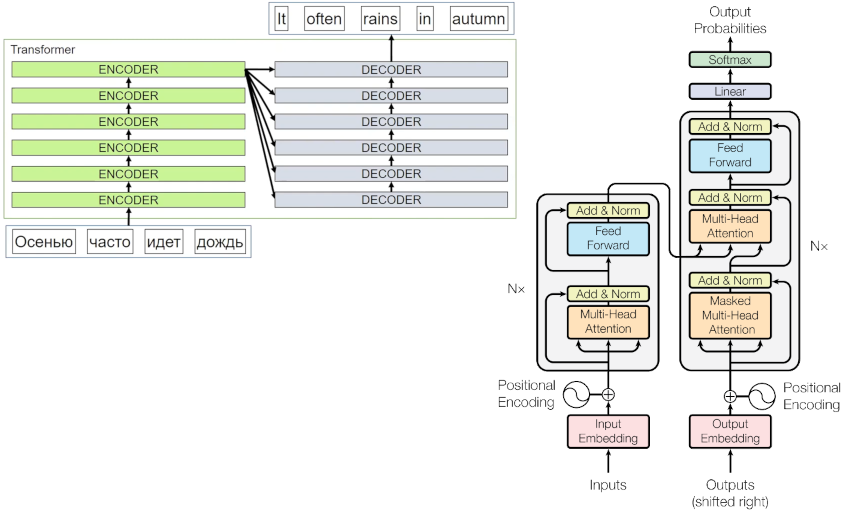

In [16]:
import torch.nn as nn
import torch.nn.functional as F

## Positional encoding 

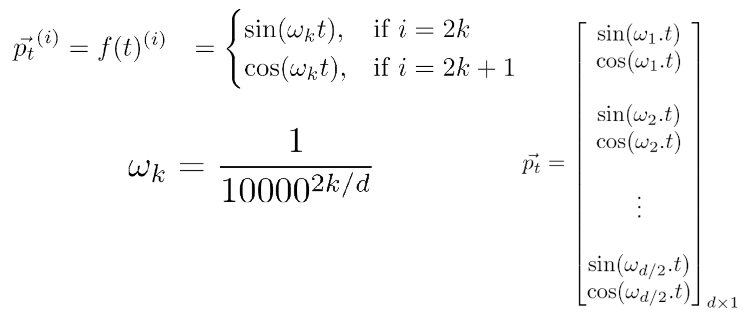

t – номер слова в строке;   
d – размерность входа модели;   
k – номер элемента в векторе PE;    

PE – не обучается вместе с моделью, но вычисляется по формуле 

длина последовательности ограничена 

In [17]:
class PositionalEncoding(nn.Module):
    
    def __init__( self, vector_size, seq_len ):
        super().__init__()
        t = torch.arange(seq_len,dtype=torch.float32).reshape(-1,1)
        w = lambda k,d: 1./10_000**(2.*k/d)
        w_even = w( torch.arange( start=0, end=vector_size,  step=2, dtype=torch.float32 ),vector_size )
        w_odd  = w( torch.arange( start=1, end=vector_size+1,step=2, dtype=torch.float32 ),vector_size )
        assert (len(w_odd)+len(w_even))==vector_size
        assert len(w_odd)==len(w_even)
        self._data = torch.hstack([torch.cos(w_even*t).T,torch.cos(w_odd*t).T, ]).reshape(vector_size,seq_len).T

    def forward(self,n):
        return self._data[n]

In [18]:
# PositionalEncoding(128,7)([2,3,4]).shape

In [19]:
class InputTransformer(nn.Module):
    
    def __init__(self, vocabulary_len, embedding_dim, seq_len):
        super().__init__()
        self._emb = nn.Embedding(vocabulary_len,embedding_dim)
        self._pe = PositionalEncoding(vector_size=embedding_dim,seq_len=seq_len)
               
    def forward(self,x):
        device = next(self._emb.parameters()).device # устройство модели
        o = self._emb(x)
        n_samples, seq_len, emb_size = o.size()
        pe = self._pe(torch.arange(seq_len,dtype=torch.long)).unsqueeze(0).to(device)
        o = (o+pe)
        return o  

In [20]:
# x,t = ds[:2]
# seq_len=x.size(-1)

# InputTransformer(vzocabulary_len=len(ds.vocabulary),seq_len=seq_len)(x).shape

# x,seq_len

## Attention

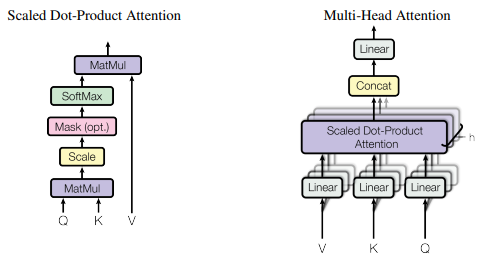

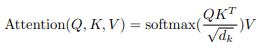

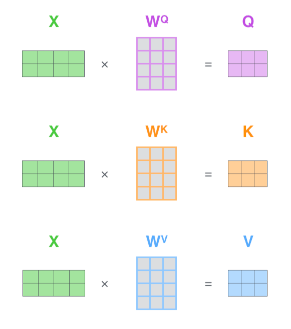

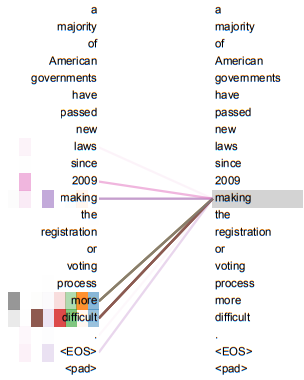

In [21]:
import math

class EncoderDecoderAttention(nn.Module):
    
    def __init__(self,in_size,w_size):
        super().__init__()
        self._query = nn.Linear( in_features=in_size, out_features=w_size, bias=False )
        self._w_factor = math.sqrt(w_size)
        
    def forward(self,x,K,V):
        Q=self._query(x)
        return self._attention(Q,K,V,)
    
    def _attention(self,Q,K,V): 
        return torch.bmm( 
                F.softmax( 
                    torch.bmm(Q,K.transpose(-1,-2))/self._w_factor
                    ,dim=-1) 
                ,V 
            )

In [22]:
class SelfAttention(EncoderDecoderAttention):
    
    def __init__(self,in_size,w_size):
        super().__init__(in_size,w_size)
        self._key   = nn.Linear( in_features=in_size, out_features=w_size, bias=False )
        self._value = nn.Linear( in_features=in_size, out_features=w_size, bias=False )

    def forward(self,x):
        K=self._key(x)       
        V=self._value(x) 
        return (K,V), super().forward(x,K,V)

In [23]:
# n_samples, n_seq, emb_size, w_size = 2,3,4,5

# x = torch.rand(n_samples,n_seq,emb_size)
# display( x.shape )

# (k,v),o = SelfAttention(emb_size,w_size).forward(x)
# display( ( (k.shape,v.shape),o.shape ) )

# o = EncoderDecoderAttention(emb_size,w_size).forward(x,k,v)
# display( o.shape )

In [24]:
class MultiHeadedSelfAttention(nn.Module):
    
    def __init__(self, in_size, w_size, n_head ):
        super().__init__()
        # FIXME: неоптимальная реализация, блоки Attention считаются последовательно 
        self._att = nn.ModuleList([ SelfAttention(in_size,w_size) for _ in range(n_head) ])
        self._lin = nn.Linear( in_features=n_head*w_size, out_features=in_size, bias=True, )
        
    def forward(self,x):
        o = [ a(x) for a in self._att ]
        (k,_),_ = o[-1]
        (_,v),_ = o[-1]
        o = torch.cat([ a for (_,_),a in o ],dim=-1)
        o = self._lin(o)
        return (k,v),o

In [25]:
class MultiHeadedEncoderDecoderAttention(nn.Module):
    
    def __init__(self, in_size, w_size, n_head ):
        super().__init__()
        # FIXME: неоптимальная реализация, блоки Attention считаются последовательно 
        self._att = nn.ModuleList([ EncoderDecoderAttention(in_size,w_size) for _ in range(n_head) ])
        self._lin = nn.Linear( in_features=n_head*w_size, out_features=in_size, bias=True, )
        
    def forward(self,x,k,v):
        o = torch.cat([ a(x,k,v) for a in self._att ],dim=-1)
        o = self._lin(o)
        return o

In [26]:
# n_samples = 2
# seq_len,emb_size = 3,4
# w_size = 5
# n_head = 7
# out_size = 9

# x = torch.rand(n_samples,seq_len,emb_size)
# display( x.shape )

# (k,v),o = MultiHeadedSelfAttention( 
#         in_size=emb_size, 
#         w_size=w_size, 
#         n_head=n_head,
#     ).forward(x) #.shape

# display( (k.shape,v.shape, o.shape ) )

In [27]:
# o = MultiHeadedEncoderDecoderAttention( 
#         in_size=emb_size, 
#         w_size=w_size, 
#         n_head=n_head,
#     ).forward(x,k,v)

# display( o.shape )

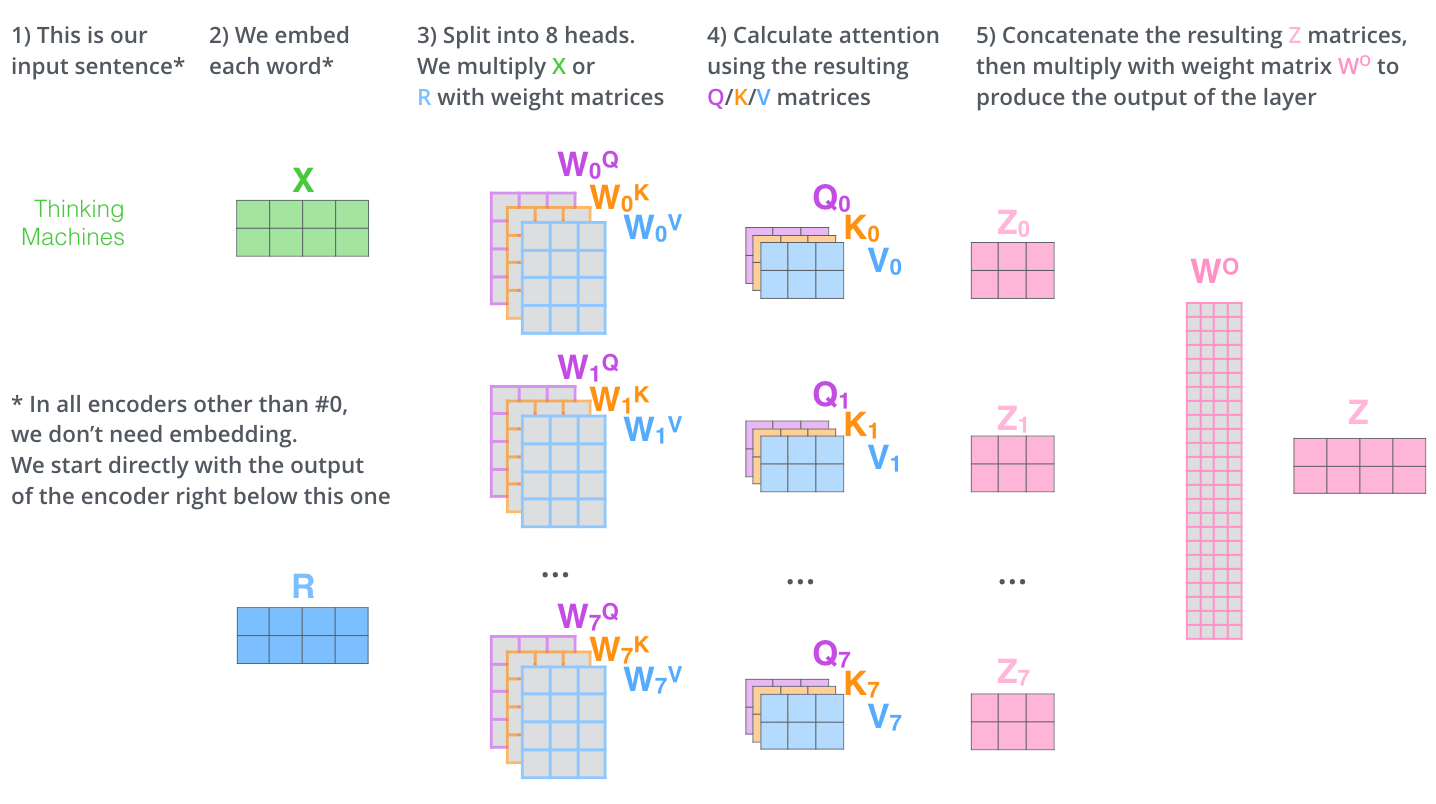

---

## Encoder

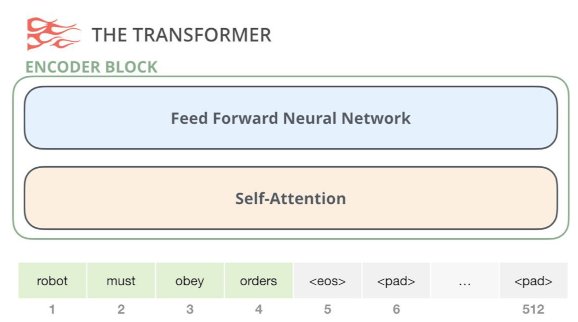

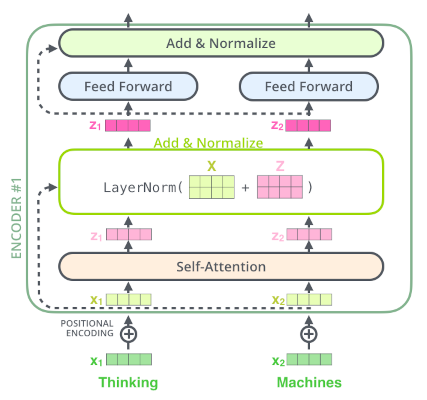

In [28]:
class Encoder(nn.Module):
    
    def __init__(self, in_size, n_head, w_size ):
        super().__init__()
        self._msa = MultiHeadedSelfAttention( in_size=in_size, w_size=w_size, n_head=n_head,)
        self._norm1 = nn.LayerNorm(in_size) 
        self._lin = nn.Linear( in_features=in_size, out_features=in_size, bias=True, )
        self._norm2 = nn.LayerNorm(in_size) 

    def forward(self,x):
        (k,v),z = self._msa(x)
        z = self._norm1(z+x)
        o = self._lin(z)
        o = self._norm2(z+o)
        return (k,v),o

In [29]:
# x,t = ds[:2]
# with torch.set_grad_enabled(False): # генерируем следующий токен
#     o = InputTransformer(vocabulary_len=len(ds.vocabulary),embedding_dim=128,seq_len=9).forward(x)
#     (k,v),o = Encoder(in_size=128, n_head=8, w_size=64 ).forward( o )
# display(k.shape,v.shape,o.shape)

In [30]:
class EncoderStack(nn.Module):
    
    def __init__(self, vocabulary, seq_len, embedding_dim=128, n_head=8, w_size=128, n_modules=2 ):
        super().__init__()
        self._vocabulary = vocabulary
        self._input = InputTransformer(vocabulary_len=len(vocabulary),embedding_dim=embedding_dim,seq_len=seq_len)

        self._encoders = nn.ModuleList([ 
            Encoder(in_size=embedding_dim,n_head=n_head,w_size=w_size) 
            for _ in range(n_modules) ])
            
    def forward(self,x):
        key,value = [],[]
        o = self._input(x)
        for enc in self._encoders:
            (k,v),o = enc(o)
            key.append(k)
            value.append(v)
        return (key,value),o

In [31]:
# x,t = ds[:2]
# model = EncoderStack(ds.vocabulary,embedding_dim=128,seq_len=ds.sequence_len,n_head=8,w_size=128,n_modules=2)

# with torch.set_grad_enabled(False): # генерируем следующий токен
#     (k,v),o = model.forward(x)

# display(k[0].shape,v[0].shape,o.shape)

## Decoder

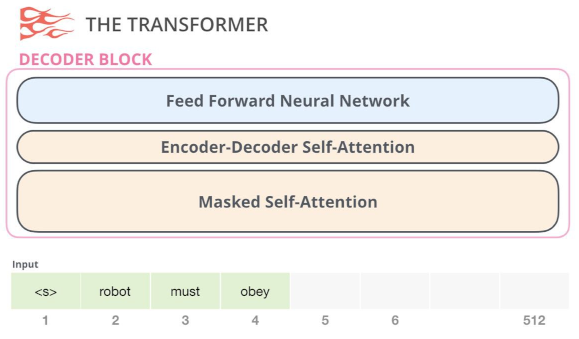

Ключевая разница с Encoder заключается в механизме работы слоя внутреннего внимания и состоит в том, что здесь будущие токены маскируются с помощью изменения процесса подсчета внутреннего внимания и блокирования информации от токенов, находящихся справа от той позиции, которая высчитывается в данный момент.

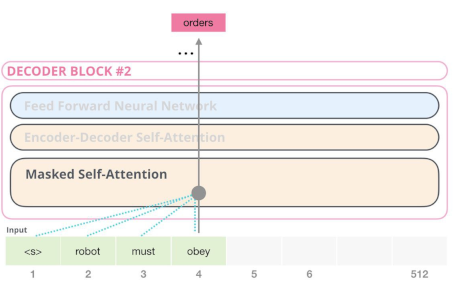

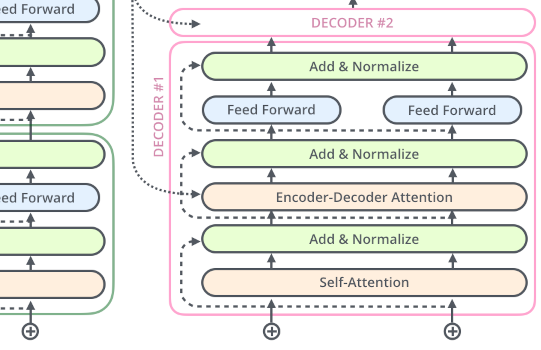

In [32]:
class Decoder(nn.Module):
    
    def __init__(self, in_size, n_head, w_size ):
        super().__init__()
        self._msa = MultiHeadedSelfAttention(in_size=in_size,w_size=w_size,n_head=n_head,)
        self._norm0 = nn.LayerNorm(in_size) 
        self._meda = MultiHeadedEncoderDecoderAttention(in_size=in_size,w_size=w_size,n_head=n_head,)
        self._norm1 = nn.LayerNorm(in_size) 
        self._lin = nn.Linear( in_features=in_size, out_features=in_size, bias=True, )
        self._norm2 = nn.LayerNorm(in_size) 
        
    def forward(self,x,k,v):
        _,z = self._msa(x)
        o = self._norm0(z+x)
        z = self._meda(o,k,v)
        o = self._norm1(o+z)
        o = self._lin(o)
        o = self._norm2(z+o)
        return o

In [33]:
# x,t = ds[:2]
# with torch.set_grad_enabled(False): # генерируем следующий токен
#     o = InputTransformer(vocabulary_len=len(ds.vocabulary),embedding_dim=128,seq_len=9).forward(x)
#     (k,v),o = Encoder(in_size=128, n_head=8, w_size=64).forward( o )
#     o = Decoder(in_size=128, n_head=8, w_size=64).forward( o,k,v )

# display(k.shape,v.shape,o.shape)

In [34]:
class DecoderStack(nn.Module):
    
    def __init__(self, vocabulary, seq_len, embedding_dim=128, n_head=8, w_size=128, n_modules=2 ):
        super().__init__()
        self._vocabulary = vocabulary
        self._seq_len = seq_len
        
        self._input = InputTransformer(vocabulary_len=len(vocabulary),embedding_dim=embedding_dim,seq_len=seq_len)
        self._decoders = nn.ModuleList([ 
            Decoder(in_size=embedding_dim,n_head=n_head,w_size=w_size) 
            for _ in range(n_modules) ])
        self._lin = nn.Linear( in_features=embedding_dim*seq_len, out_features=len(vocabulary), bias=True, )
        
        
    def _forward_step(self,x,keys,values):
        assert len(keys)==len(values)
        assert len(keys)==len(self._decoders)
        
        o = self._input(x)
        for i,dec in enumerate(self._decoders):
            o = dec(o,keys[i],values[i])
        o = torch.flatten(o, start_dim=1)
        o = self._lin(o)
        o = F.log_softmax(o,dim=-1)            
        return o
    
    
    # рабочий режим - по авторегрессионной схеме генерируем последовательность длиной seq_max
    def forward( self, keys, values, seq_len=5 ):
        assert len(keys)==len(values)
        assert len(keys)==len(self._decoders)
        
        device = next(self._lin.parameters()).device # устройство модели
        batch_size = keys[0].size(0)
        x = self._build_zero_input(batch_size) # начальный вход
        
        codes = [] # выходная последовательность
        for i in range(seq_len):
            o = self._forward_step(x.to(device),keys,values)
            o = torch.argmax(o,dim=-1, keepdim=True).cpu() # определяем номер токена-победителя
            codes.append(o)
            x = self._shift_input(x,o,i) # сдвигаем вход и добавляем новый токен
        return torch.cat(codes,dim=-1)
    
            
    # учебный режим - генерируем последовательность длинной как у target
    # по схеме teacher forcing, на каждой итерации заменяем вход на значение из target
    def forward_train(self,keys,values, target):
        device = next(self._lin.parameters()).device # устройство модели
        batch_size = target.size(0)
        
        # начальный вход
        x = self._build_zero_input(batch_size)
        
        outputs = []  # выходы модели 
        for i in range(self._seq_len):
            o = self._forward_step(x.to(device),keys,values)
            outputs.append(o.unsqueeze(1))
            # teacher forcing: заменяем выход модели на предыдущей итерации на target
            t = target[:,[i]]
            x = self._shift_input(x,t,i)
        return torch.cat(outputs,dim=1)
    
    def _shift_input(self,x,t,pos): # сдвигаем вход и добавляем новый токен
        last_pos = x.size(-1)-1
        if pos>last_pos:
            return torch.cat([x[:,1:],t], dim=-1) 
        return torch.cat([x[:,:pos],t,x[:,pos+1:] ], dim=-1) 
             
            
    def _build_zero_input(self,batch_size):
        return torch.cat([ 
                torch.ones(batch_size,1,dtype=torch.long) * self._vocabulary['<BOS>'], 
                torch.zeros(batch_size,self._seq_len-1,dtype=torch.long), 
            ], dim=-1 ) 
        # ( <bos>,0,...,0 )

In [35]:
# x,t = ds[:2]

# model_enc = EncoderStack(ds.vocabulary,embedding_dim=128,seq_len=ds.sequence_len,n_head=8,w_size=128,n_modules=2)
# model_dec = DecoderStack(ds.vocabulary,embedding_dim=128,seq_len=ds.sequence_len,n_head=8,w_size=128,n_modules=2)

# with torch.set_grad_enabled(False): # генерируем следующий токен
#     (k,v),o = model_enc.forward(x)
#     o = model_dec.forward_train(k,v,t)
#     #o = model_dec.forward(k,v,seq_len=17)
    
# display(k[0].shape,v[0].shape,o.shape)

## собираем все части вместе


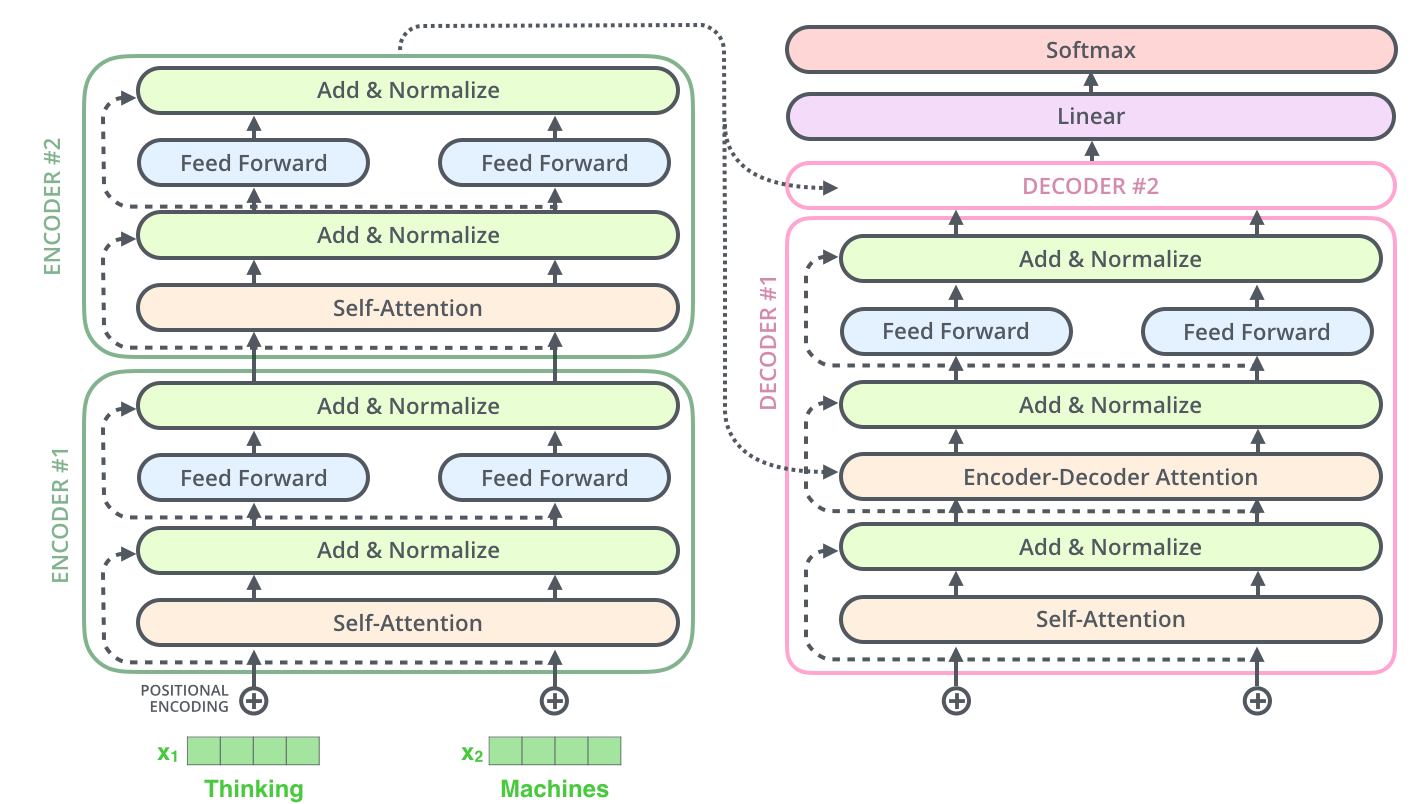

In [36]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display( device )
display( torch.cuda.get_device_name() )

device(type='cuda', index=0)

'Tesla P40'

In [37]:
embedding_dim=256
w_size=64
n_head=8
n_modules=2

model_encoder = EncoderStack(
        vocabulary=ds.vocabulary,
        seq_len=ds.sequence_len,
        embedding_dim=embedding_dim,
        n_head=n_head,
        w_size=w_size,
        n_modules=n_modules,
    ).to(device)

model_decoder = DecoderStack(
        vocabulary=ds.vocabulary,
        seq_len=ds.sequence_len,
        embedding_dim=embedding_dim,
        n_head=n_head,
        w_size=w_size,
        n_modules=n_modules,
    ).to(device)

In [38]:
# x,t = ds[7:17]
# with torch.set_grad_enabled(False): # генерируем следующий токен
#     (k,v),o = model_encoder.forward(x.to(device))
#     o = model_decoder.forward(k,v,seq_max=3)
#     # o = model_decoder.predict(x.to(device),k,v)

# display(k[0].shape,v[0].shape,o.shape)

# обучаем 

In [39]:
from torch import optim

learning_rate = 1e-3

criterion = nn.NLLLoss()

encoder_optimizer = optim.Adam( model_encoder.parameters(), lr=learning_rate )
decoder_optimizer = optim.Adam( model_decoder.parameters(), lr=learning_rate )

In [40]:
# история значений ф-ции потери
loss_history = [] 

In [41]:
from torch.utils.data import DataLoader

In [82]:
%%time

n_epoch = 8 # количество эпох обучения
batch_size = 128

for i in tqdm(range(n_epoch)): 
    loss_batch = []
    
    # получаем батч учебных примеров
    for encoder_input, target in DataLoader( ds, batch_size=batch_size, shuffle=True): 
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        (k,v),o = model_encoder.forward(encoder_input.to(device))
        decoder_outputs = model_decoder.forward_train(k,v,target)
        
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target.to(device).view(-1)
        )
        loss_batch.append(loss.item()) # дополняем историю изменения значений ф-ции потери на батче
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()
   
    loss_history.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери


  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 8min 41s, sys: 51.1 s, total: 9min 32s
Wall time: 9min 33s


Text(0.5, 1.0, 'min loss: 0.09393')

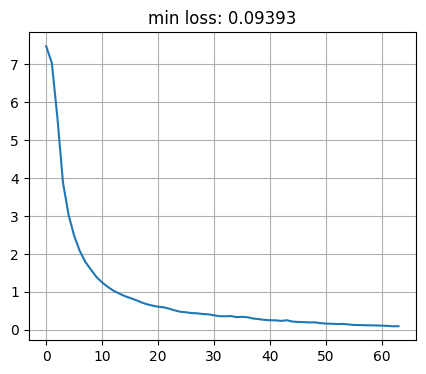

In [83]:
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(5,4))
ax.plot(loss_history)
ax.grid()
ax.set_title(f'min loss: {min(loss_history):.5f}')

# тестируем

In [87]:
from random import sample
from nltk.util import ngrams 

prompts = sample([
        ' '.join(ng) 
        for s in sample( ds.sentences,128 ) 
        if len(s)>ds.sequence_len*2
        for ng in list(ngrams(s[:ds.sequence_len],ds.sequence_len-1))  
    ],5)

display( prompts )

['я выехал на Парк-авеню по Тридцатой и юркнул',
 'Я вытер выступивший на лбу пот и игриво',
 'Вообразите , что с вами сделает пройда ,',
 'Два черных и два коричневых ... Еще совсем',
 'Согнав шоферюг в нестройную шеренгу , Фрэнк расхаживал']

In [88]:
class LangModelTransformer: # генератор текста 
    
    def __init__(self,encoder,decoder,vocabulary):
        self._encoder = encoder 
        self._decoder = decoder 
        self._vocabulary = vocabulary # словарь языковой модели
        self._vocabulary_inv = { v:k for k,v in self._vocabulary.items() }
    
    def predict(self,prompt,seq_len=10):
        codes = self._predict( self._encode(prompt), seq_len) # генерируем коды токенов
        return self._strip_eos( self._decode(np.hstack(codes)) ) # конвертируем коды токенов в строку
    
    def _predict(self,x,seq_len):
        device = next(self._encoder.parameters()).device 
        with torch.set_grad_enabled(False): # генерируем следующий токен
            (k,v),_ = self._encoder.forward(x.to(device))
            codes = self._decoder.forward(k,v,seq_len)
        return codes
    
    def _encode(self,s): # кодируем строку
        s = nltk_tokenize_word(s,language='russian')
        s = [ self._vocabulary[w] for w in s if (w in self._vocabulary) ]
        return torch.tensor([s], dtype=torch.long )
    
    def _decode(self,s): # конвертируем коды токенов в строку
        return ' '.join([ 
            self._vocabulary_inv[c] 
            for c in s if (c in self._vocabulary_inv) 
        ])
    
    @staticmethod
    def _strip_eos(s, eos = '<EOS>'):
        n = s.find(eos)
        return s if n<0 else s[:n+len(eos)]

In [89]:
generator = LangModelTransformer(model_encoder,model_decoder,ds.vocabulary)

for prompt in prompts:
    t = generator.predict(prompt,seq_len=15)
    print(prompt,'==>', t,'\n')

я выехал на Парк-авеню по Тридцатой и юркнул ==> у входа в `` Пан-Ам '' и Пан-Ам '' '' . <EOS> 

Я вытер выступивший на лбу пот и игриво ==> локтем сидевшего рядом пригорюнившегося еврея : -- Ну-ка , если известно мне -- цок ! 

Вообразите , что с вами сделает пройда , ==> и теперь вы оказались после бессонных вас и сделал же -- как вас сделал ! 

Два черных и два коричневых ... Еще совсем ==> я , как и вы , и инициалом `` '' -- ведь и надел гудок 

Согнав шоферюг в нестройную шеренгу , Фрэнк расхаживал ==> , взад и вперед и вперед : обливаясь в окно , обливаясь мне ведь и 



---

In [ ]:
# Знакомство с трансформерами
# https://habr.com/ru/companies/wunderfund/articles/592231/

In [ ]:
# class MultiHeadedEncoderDecoderAttention(nn.Module):

#     def __init__(self, in_size, w_size, n_head):
#         super().__init__()
#         self._n_head = n_head
#         self._emb_size = in_size
#         self._w_size = w_size
#         self._queries = nn.Linear(in_size,w_size*n_head, bias=False)
#         self._lin = nn.Linear(w_size*n_head,in_size)
    
#     def forward(self, x, keys,values):
#         batch_size, seq_len, emb_size = x.size()

#         queries = self._queries(x).view( batch_size, seq_len, self._n_head, self._w_size )

#         # - преобразование данных блоков в пакет матриц
#         keys = keys.transpose(1,2).contiguous().view(batch_size*self._n_head, seq_len, self._w_size)
#         queries = queries.transpose(1,2).contiguous().view(batch_size*self._n_head, seq_len, self._w_size)
#         values = values.transpose(1,2).contiguous().view(batch_size*self._n_head, seq_len, self._w_size)
    
#         queries = queries/(self._w_size**(1./4.))
#         keys    = keys/(self._w_size**(1./4.))

#         # - получить скалярное произведение запросов и ключей, масштабировать данные
#         dot = torch.bmm(queries, keys.transpose(1,2))
#         # - размер произведения, содержащего необработанные веса - (b*h, t, t)
#         dot = F.softmax(dot, dim=2) 
#         # - произведение теперь содержит веса, нормализованные построчно

#         # применить механизм внутреннего внимания к значениям
#         out = torch.bmm(dot, values).view(batch_size, self._n_head, seq_len, emb_size )

#         # вернуть h, t, унифицировать блоки внутреннего внимания
#         out = out.transpose(1,2).contiguous().view(batch_size, seq_len, self._n_head*emb_size)
#         return (keys,values), self._lin(out)

In [ ]:
# class MultiHeadedSelfAttention(MultiHeadedEncoderDecoderAttention):

#     def __init__(self, in_size, w_size, n_head):
#         super().__init__(in_size, w_size, n_head)
#         self._keys = nn.Linear(in_size,w_size*n_head, bias=False)
#         self._values = nn.Linear(in_size,w_size*n_head, bias=False)
            
#     def forward(self, x ):
#         batch_size, seq_len, emb_size = x.size()
#         keys = self._keys(x).view( batch_size, seq_len, self._n_head, self._w_size )
#         values = self._values(x).view( batch_size, seq_len, self._n_head, self._w_size )
#         return super().forward(x,keys,values)
    

In [ ]:
# n_samples, seq_len,emb_size  = 2, 9, 128
# # n_heads,w_size = 8, 64

# o = torch.rand(n_samples,seq_len,emb_size)
# # # display( x.shape )

# # x,t = ds[:2]

# with torch.set_grad_enabled(False): # генерируем следующий токен
# #     o = InputTransformer(
# #         vocabulary_len=len(ds.vocabulary),
# #         embedding_dim=128,
# #         seq_len=ds.sequence_len,
# #     ).forward(x)
    
#     display(o.shape)

#     (k,v),o = MultiHeadedSelfAttention( 
#             in_size=128, 
#             w_size=64,
#             n_head=8,
#         ).forward(o)

# display( (k.shape,v.shape, o.shape ) )   